## Importing dataset and visualization

In [1]:
import PRF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('../'))
from utils import load_keel_dataset

file_path="../KEEL/keel_data/phoneme.dat"


X_train, X_test, y_train, y_test, label_map = load_keel_dataset(
    train_path=file_path, # Path to the WHOLE dataset (if it's not already split)
    already_split=False  # Performs the train_test split if False
) 
print("Head of training data: \n", X_train[:10])
print("Head of labels: \n", y_train[:10])

Head of training data: 
 [[ 0.981  2.268 -0.337  0.189 -0.161]
 [ 0.122  0.592  1.288  2.546 -0.849]
 [ 2.912  0.359  0.285  0.149 -0.081]
 [ 0.366  2.989 -0.515  0.331 -0.133]
 [ 0.618  1.016  2.178 -0.401  0.533]
 [ 0.349  0.794  2.317  0.913  1.411]
 [ 0.195  0.425  0.699  1.953  1.493]
 [ 0.233  0.86   2.49  -0.71   0.547]
 [ 0.086  0.353  0.724  1.399 -0.418]
 [ 0.28   0.553  0.725  1.927 -0.783]]
Head of labels: 
 [1 1 1 1 1 2 2 1 1 2]


#### Visualization

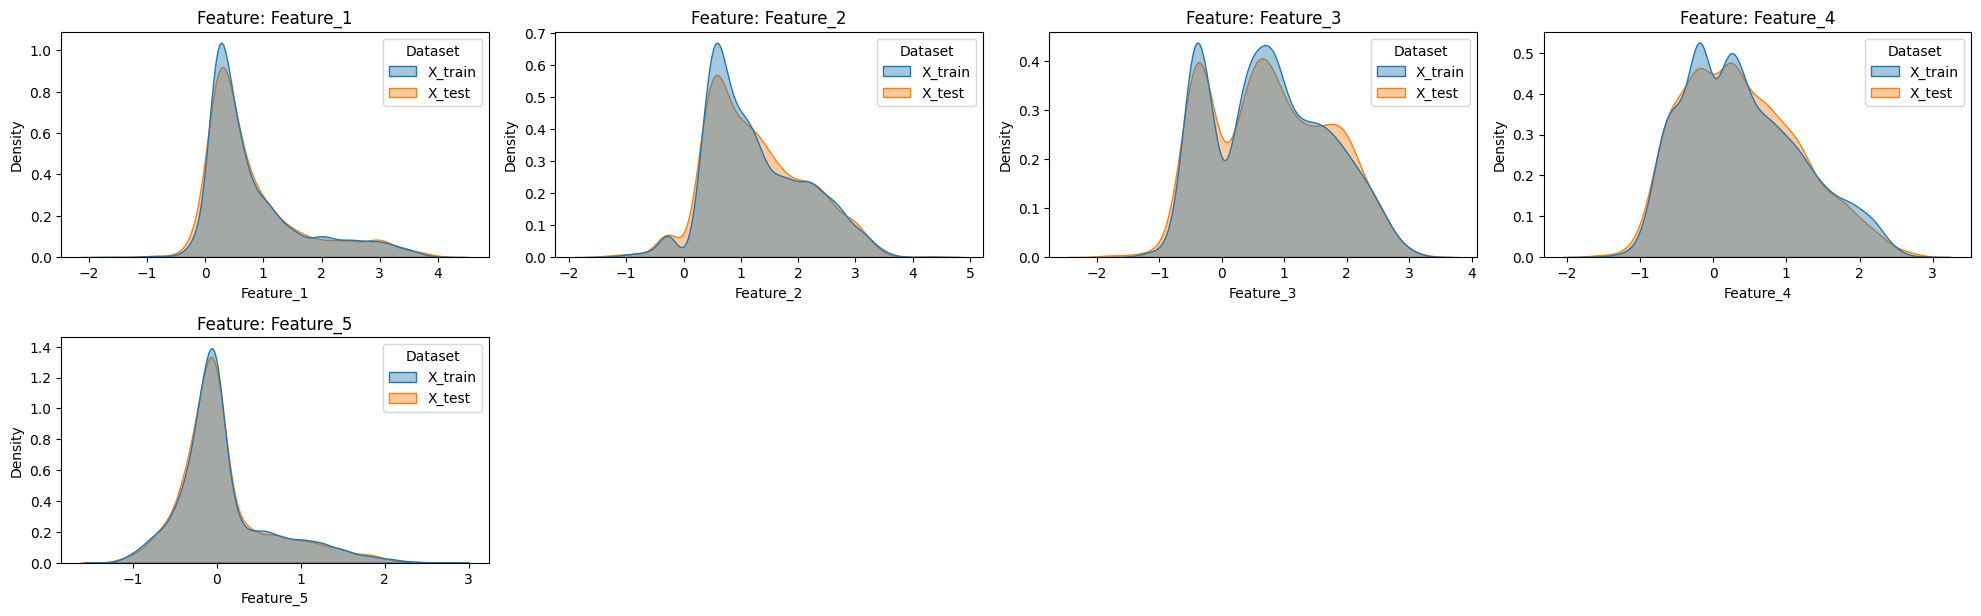

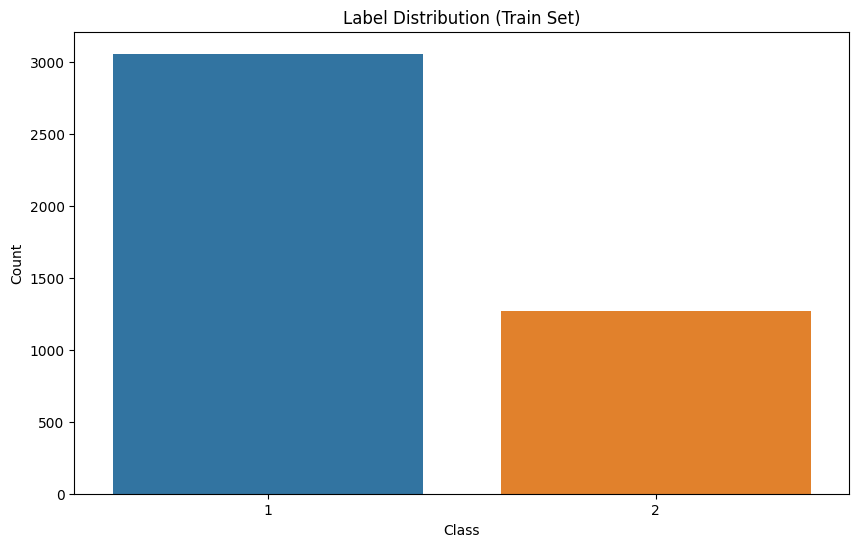

In [2]:
feature_names_train = [f'Feature_{i+1}' for i in range(X_train.shape[1])]

df1 = pd.DataFrame(X_train, columns=feature_names_train)
df1['Label'] = y_train
df1['Dataset'] = 'X_train'

feature_names_test = [f'Feature_{i+1}' for i in range(X_test.shape[1])]

df2 = pd.DataFrame(X_test, columns=feature_names_test)
df2['Label'] = y_test       # <-- Fix here: assign y_test to df2, not df1
df2['Dataset'] = 'X_test'

# Combine both train and test dataframes for plotting
df_all = pd.concat([df1, df2], ignore_index=True)

# Plot distributions of each feature side by side
plt.figure(figsize=(20, 15))
for i, feature in enumerate(feature_names_train):
    plt.subplot(5, 4, i + 1)
    sns.kdeplot(data=df_all, x=feature, hue='Dataset', common_norm=False, fill=True, alpha=0.4, bw_adjust=0.9)
    plt.title(f"Feature: {feature}")
plt.tight_layout()
plt.show()



# Plot label distribution (only for training set or combined if you want)
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df1, order=sorted(df1['Label'].unique()))
plt.title("Label Distribution (Train Set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


#### Adding noise

In [3]:
# NOTE: THIS CODE MAKES LITTLE SENSE IF THERE ARE BOUNDS IN AN INTERVAL OF A FEATURE (LIKE IT HAS TO BE BETWEEN 0 AND 1)

from utils.noising import add_noise

X_train_noisy, _, dX, _ = add_noise(X_train, noise_type='gaussian', gaussian_scale=0.6)
# Printing noise head (dX):
print("Head of noise (dX): \n", dX[:5])

Head of noise (dX): 
 [[-0.30940462  0.64828692  0.20809213  0.4011999  -0.04256757]
 [ 0.99793362  0.41953508  0.41283871 -0.11825956  0.25394991]
 [ 0.33165502 -0.30648428 -0.14194749  0.15704311 -0.1882762 ]
 [ 0.12133561 -0.31834578  0.59263456  0.22817605  0.19166252]
 [-0.11727362 -1.17790155  0.55326649 -0.11006096  0.04789163]]


In [4]:
# TODO: Noise for labels (?), other types of noise

#### Visualizing noise

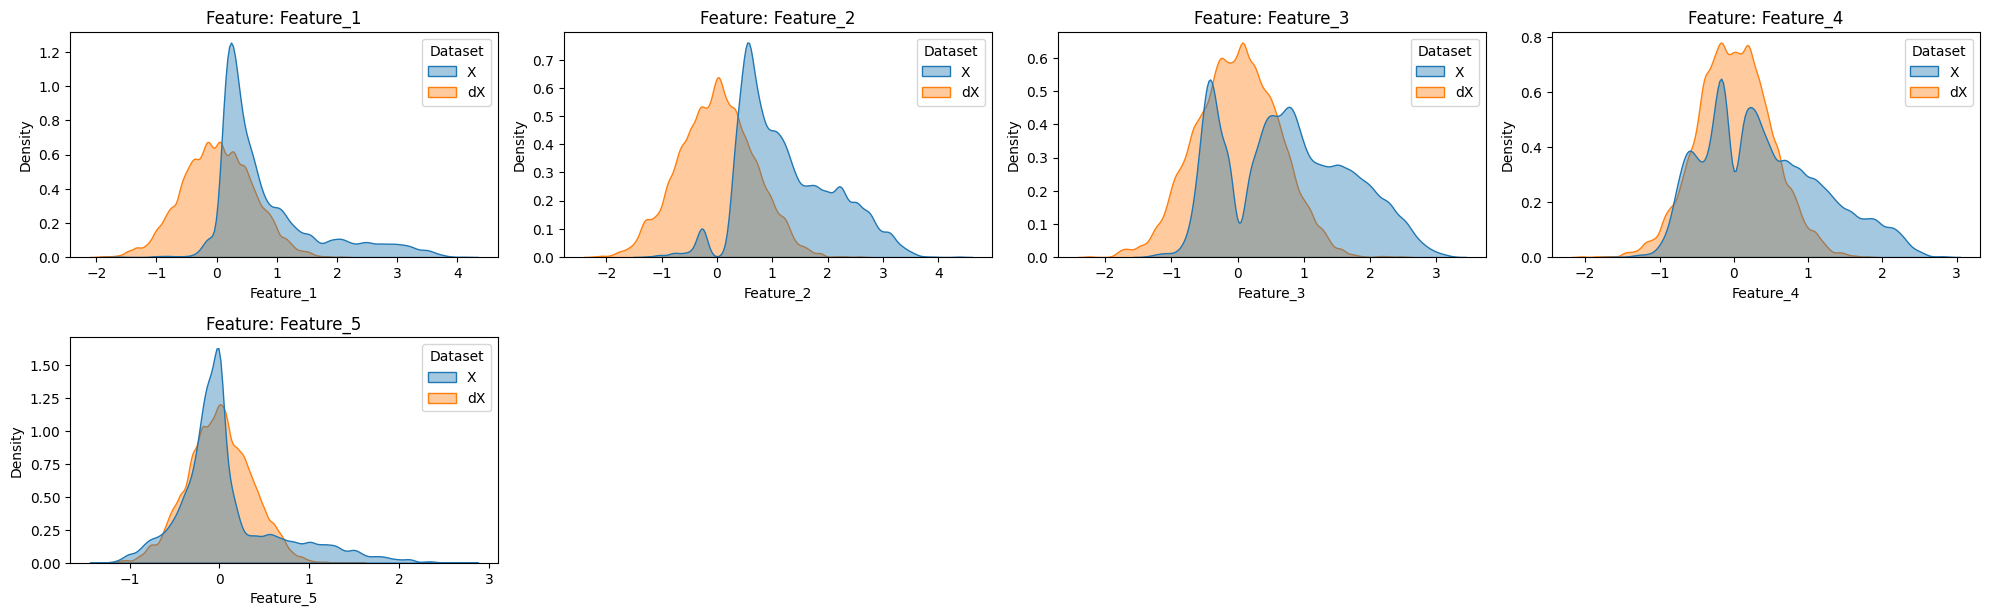

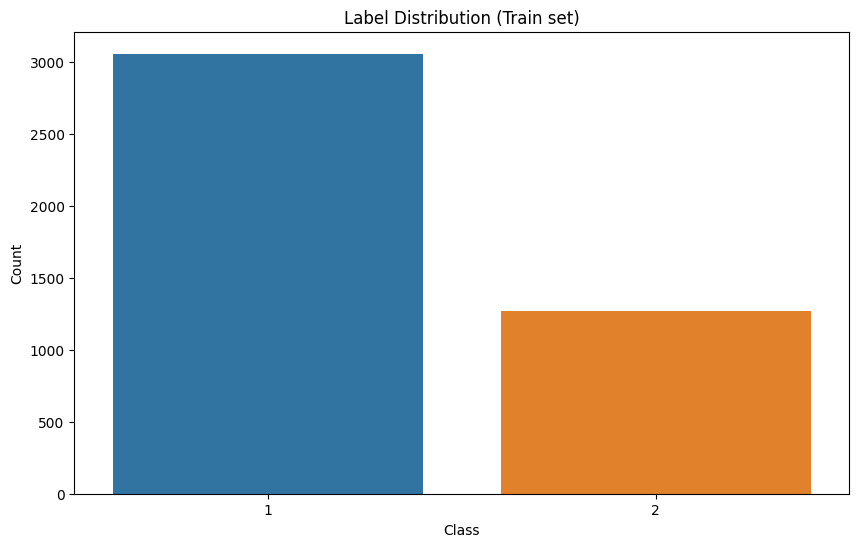

In [5]:
feature_names = [f'Feature_{i+1}' for i in range(X_train.shape[1])]

df1 = pd.DataFrame(X_train, columns=feature_names)
df1['Label'] = y_train
df1['Dataset'] = 'X'

df2 = pd.DataFrame(dX, columns=feature_names)
df2['Dataset'] = 'dX'

# Combine both for easier plotting
df_all = pd.concat([df1, df2], ignore_index=True)

# Plot distributions of each feature side by side
plt.figure(figsize=(20, 15))
for i, feature in enumerate(feature_names):
    plt.subplot(5, 4, i + 1)
    sns.kdeplot(data=df_all, x=feature, hue='Dataset', common_norm=False, fill=True, alpha=0.4, bw_adjust=0.5)
    plt.title(f"Feature: {feature}")
plt.tight_layout()
plt.show()

# Plot label distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df1, order=sorted(df1['Label'].unique()))
plt.title("Label Distribution (Train set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## SETTING SEEDS

In [6]:
import numpy as np
import random
import tensorflow as tf
import os

def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

SEEDS = [27, 272, 2727, 1, 30, 50, 10, 9, 31, 67]


2025-06-09 11:59:46.062216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-09 11:59:46.243386: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 11:59:46.255988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/gurobi1102/win64/lib:/usr/local/gurobi1102/win64/lib
2025-06-09 11:59:46.256011: I

## PDRF

In [7]:
from deepforest import CascadeForestClassifier
import PRF4DF

n_cascade_estimators = 4
n_classes = len(label_map)
n_features = X_train.shape[1]

accuracies_PDRF = []

for seed in SEEDS:
    set_all_seeds(seed)

    model = CascadeForestClassifier(
        n_bins=n_classes,
        random_state=seed,
    )

    prf_estimators = []
    for i in range(n_cascade_estimators):
        estimator = PRF4DF.SklearnCompatiblePRF(
            n_classes_=n_classes,
            n_features_=n_features,
            use_probabilistic_labels=False,
            use_feature_uncertainties=True,
            n_estimators=10,
            max_depth=10,
            random_state=i,
            n_jobs=1
        )
        prf_estimators.append(estimator)

    model.set_estimator(prf_estimators)

    X_train_combined = np.hstack((X_train_noisy, dX))
    model.fit(X=X_train_combined, y=y_train)

    X_test_combined = np.hstack((X_test, np.zeros_like(X_test)))
    acc = model.score(X_test_combined, y_test)
    accuracies_PDRF.append(acc)

mean_acc = np.mean(accuracies_PDRF)
std_acc = np.std(accuracies_PDRF)
print(f"PDRF Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


[2025-06-09 09:59:48.225] Start to fit the model:
[2025-06-09 09:59:48.225] Fitting cascade layer = 0 
[2025-06-09 09:59:58.363] layer = 0  | Val Acc = 70.669 % | Elapsed = 10.138 s
[2025-06-09 09:59:58.368] Fitting cascade layer = 1 
[2025-06-09 10:00:07.847] layer = 1  | Val Acc = 72.982 % | Elapsed = 9.480 s
[2025-06-09 10:00:07.852] Fitting cascade layer = 2 
[2025-06-09 10:00:17.163] layer = 2  | Val Acc = 71.964 % | Elapsed = 9.311 s
[2025-06-09 10:00:17.163] Early stopping counter: 1 out of 2
[2025-06-09 10:00:17.167] Fitting cascade layer = 3 
[2025-06-09 10:00:26.685] layer = 3  | Val Acc = 71.964 % | Elapsed = 9.518 s
[2025-06-09 10:00:26.685] Early stopping counter: 2 out of 2
[2025-06-09 10:00:26.685] Handling early stopping
[2025-06-09 10:00:26.693] The optimal number of layers: 2
[2025-06-09 10:00:26.701] Start to evalute the model:
[2025-06-09 10:00:26.701] Evaluating cascade layer = 0 
[2025-06-09 10:00:27.865] Evaluating cascade layer = 1 
[2025-06-09 10:00:28.998] Sta

## Other methods for classification

#### Probabilistic Random Forest

In [8]:
import PRF

accuracies_PRF = []

for seed in SEEDS:
    set_all_seeds(seed)
    prf_cls = PRF.prf(n_estimators=10, bootstrap=True)
    prf_cls.fit(X=X_train_noisy, y=y_train, dX=dX)
    score = prf_cls.score(X_test, y=y_test)
    accuracies_PRF.append(score)

mean_acc = np.mean(accuracies_PRF)
std_acc = np.std(accuracies_PRF)
print(f"PRF Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


PRF Accuracy: 0.7965 ± 0.0103


#### Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

accuracies_RF = []

for seed in SEEDS:
    set_all_seeds(seed)
    rf = RandomForestClassifier(n_estimators=50, random_state=seed)
    rf.fit(X_train_noisy, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies_RF.append(acc)

mean_acc = np.mean(accuracies_RF)
std_acc = np.std(accuracies_RF)
print(f"Random Forest Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


Random Forest Accuracy: 0.7917 ± 0.0103


#### Deep Forest

In [10]:
from deepforest import CascadeForestClassifier
from sklearn.metrics import accuracy_score

accuracies_DF = []

for seed in SEEDS:
    set_all_seeds(seed)
    clf = CascadeForestClassifier(n_estimators=2, random_state=seed)
    clf.fit(X_train_noisy, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies_DF.append(acc)

mean_acc = np.mean(accuracies_DF)
std_acc = np.std(accuracies_DF)
print(f"Deep Forest Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


[2025-06-09 10:06:22.732] Start to fit the model:
[2025-06-09 10:06:22.732] Fitting cascade layer = 0 
[2025-06-09 10:06:24.309] layer = 0  | Val Acc = 75.920 % | Elapsed = 1.577 s
[2025-06-09 10:06:24.320] Fitting cascade layer = 1 
[2025-06-09 10:06:25.785] layer = 1  | Val Acc = 75.804 % | Elapsed = 1.465 s
[2025-06-09 10:06:25.785] Early stopping counter: 1 out of 2
[2025-06-09 10:06:25.791] Fitting cascade layer = 2 
[2025-06-09 10:06:27.336] layer = 2  | Val Acc = 74.161 % | Elapsed = 1.545 s
[2025-06-09 10:06:27.337] Early stopping counter: 2 out of 2
[2025-06-09 10:06:27.337] Handling early stopping
[2025-06-09 10:06:27.337] The optimal number of layers: 1
[2025-06-09 10:06:27.338] Start to evalute the model:
[2025-06-09 10:06:27.338] Evaluating cascade layer = 0 
[2025-06-09 10:06:27.402] Start to fit the model:
[2025-06-09 10:06:27.402] Fitting cascade layer = 0 
[2025-06-09 10:06:28.604] layer = 0  | Val Acc = 75.596 % | Elapsed = 1.202 s
[2025-06-09 10:06:28.611] Fitting ca

#### Neural Network

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasClassifier

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # CPU only

accuracies_NN = []

unique_classes = np.unique(y_train)
num_classes = len(unique_classes)
is_binary = num_classes == 2

if not is_binary:
    y_train_cat = to_categorical(np.searchsorted(unique_classes, y_train))
    y_test_cat = to_categorical(np.searchsorted(unique_classes, y_test))
else:
    y_train_cat = y_train
    y_test_cat = y_test

def create_model(hidden_units=64, dropout_rate=0.5, optimizer='adam'):
    model = Sequential()
    model.add(Dense(hidden_units, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_rate))
    if is_binary:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

for seed in SEEDS:
    set_all_seeds(seed)
    
    model = KerasClassifier(model=create_model, hidden_units=64, dropout_rate=0.5,
                            optimizer='adam', epochs=20, batch_size=16, verbose=0)
    
    model.fit(X_train_noisy, y_train_cat)

    if is_binary:
        y_pred = model.predict(X_test)
        y_true = y_test
    else:
        y_pred = np.argmax(model.predict_proba(X_test), axis=1)
        y_true = np.searchsorted(unique_classes, y_test)

    acc = accuracy_score(y_true, y_pred)
    accuracies_NN.append(acc)

mean_acc = np.mean(accuracies_NN)
std_acc = np.std(accuracies_NN)
print(f"Neural Network Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


2025-06-09 12:07:25.165399: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/gurobi1102/win64/lib:/usr/local/gurobi1102/win64/lib
2025-06-09 12:07:25.165573: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-06-09 12:07:25.165645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MSI): /proc/driver/nvidia/version does not exist
2025-06-09 12:07:25.166759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate comp

Neural Network Accuracy: 0.7667 ± 0.0047


#### Bayesian Logistic Regression (??)

#### Kernel SVM

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

accuracies_KSVM = []

# Use first seed for reproducibility
set_all_seeds(SEEDS[0])

# Define model and parameter grid
model = SVC()
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# Perform GridSearchCV once
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_noisy, y_train)

# Get best model
best_svm = grid.best_estimator_

# Predict and evaluate
y_pred = best_svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)

# Repeat accuracy 5 times to match output shape of other models
accuracies_KSVM = [acc] * len(SEEDS)

# Print mean ± std
mean_acc = np.mean(accuracies_KSVM)
std_acc = np.std(accuracies_KSVM)
print(f"Kernel SVM Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


Kernel SVM Accuracy: 0.7835 ± 0.0000


## Results Comparison

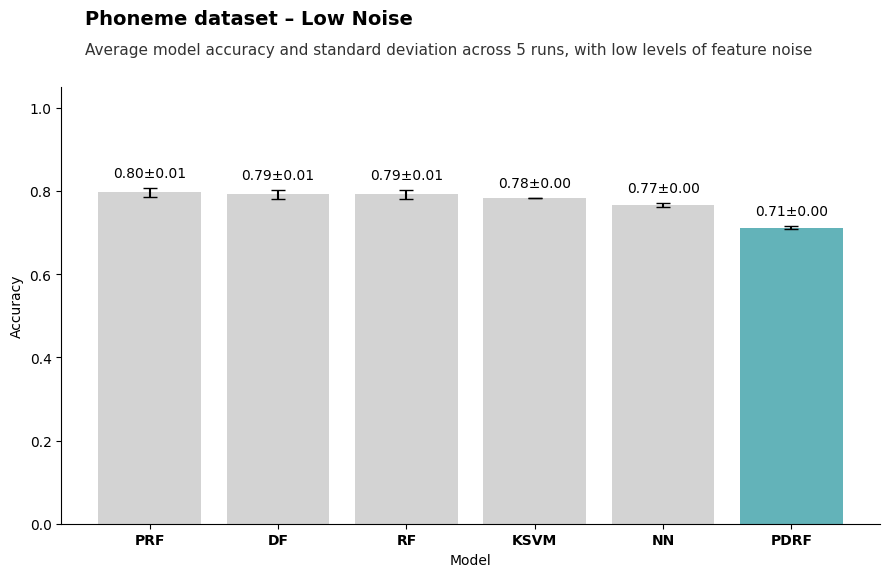

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# === Assumes these variables already exist ===
# - file_path (e.g., "../KEEL/keel_data/phoneme.dat")
# - accuracies_PDRF, accuracies_PRF, ..., accuracies_KSVM

# 1. Build comparison DataFrame
comparison_df = pd.DataFrame({
    "Model": ["PDRF", "PRF", "DF", "RF", "NN", "KSVM"],
    "Mean Accuracy": [
        np.mean(accuracies_PDRF),
        np.mean(accuracies_PRF),
        np.mean(accuracies_DF),
        np.mean(accuracies_RF),
        np.mean(accuracies_NN),
        np.mean(accuracies_KSVM),
    ],
    "Std": [
        np.std(accuracies_PDRF),
        np.std(accuracies_PRF),
        np.std(accuracies_DF),
        np.std(accuracies_RF),
        np.std(accuracies_NN),
        np.std(accuracies_KSVM),
    ]
})

# 2. Sort by mean accuracy
comparison_df = comparison_df.sort_values("Mean Accuracy", ascending=False)

# 3. Color highlight for PDRF
def get_color(model):
    return "#55bfc7" if model == "PDRF" else "lightgray"
colors = comparison_df["Model"].apply(get_color)

# 4. Extract base name from file path
base_name = os.path.splitext(os.path.basename(file_path))[0]  # e.g., "phoneme"
title_name = base_name.replace('_', ' ').title()              # e.g., "Phoneme"

# Prepare output path
output_dir = "../results/1_low_noise/plots/"
os.makedirs(output_dir, exist_ok=True)
output_filename = os.path.join(output_dir, f"{base_name}_low_noise.png")


# 5. Create the plot
fig, ax = plt.subplots(figsize=(9, 6))

# Bar plot
sns.barplot(
    data=comparison_df,
    x="Model",
    y="Mean Accuracy",
    palette=colors,
    errorbar=None,
    ax=ax
)

# Manual error bars
x_positions = range(len(comparison_df))
means = comparison_df["Mean Accuracy"].values
stds = comparison_df["Std"].values
ax.errorbar(
    x=x_positions,
    y=means,
    yerr=stds,
    fmt='none',
    ecolor='black',
    elinewidth=1.5,
    capsize=5
)

# Axis labels and limits
ax.set_ylabel("Accuracy")
ax.set_xlabel("Model")
ax.set_ylim(0, 1.05)
sns.despine()

# Annotate above error bars
for x, (mean, std) in enumerate(zip(means, stds)):
    ax.text(
        x, mean + std + 0.02,
        f'{mean:.2f}±{std:.2f}',
        ha='center', va='bottom',
        fontsize=10, color='black'
    )

# Bold model names
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')

# Left-aligned title and subtitle
fig.text(
    0.1, 0.93,
    f"{title_name} dataset – Low Noise",
    ha='left',
    fontsize=14,
    fontweight='bold'
)
fig.text(
    0.1, 0.88,
    "Average model accuracy and standard deviation across 5 runs, with low levels of feature noise",
    ha='left',
    fontsize=11, color = "#333333"
)

# Adjust layout to leave space for the text above
plt.tight_layout(rect=[0, 0, 1, 0.85])

# Save figure
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.show()


#### Saving results

In [1]:
results_df = pd.DataFrame({
    "Model": ["PDRF", "PRF", "DF", "RF", "NN", "KSVM"],
    "Mean Accuracy": [
        np.mean(accuracies_PDRF),
        np.mean(accuracies_PRF),
        np.mean(accuracies_DF),
        np.mean(accuracies_RF),
        np.mean(accuracies_NN),
        np.mean(accuracies_KSVM),
    ],
    "Std": [
        np.std(accuracies_PDRF),
        np.std(accuracies_PRF),
        np.std(accuracies_DF),
        np.std(accuracies_RF),
        np.std(accuracies_NN),
        np.std(accuracies_KSVM),
    ],
    "Seeds": [SEEDS] * 6
})

results_df.to_csv("../results/1_low_noise/tables/"+f"{base_name}_low_noise.csv", index=False)
print("Saved to results/1_low_noise/tables/"+f"{base_name}_low_noise.csv")


NameError: name 'pd' is not defined